In [1]:
import os, sys, glob, csv
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import numpy as np
import pandas as pd
import shutil
import pickle
import tqdm
from tqdm import tqdm
import xlsxwriter
import random
from random import shuffle
from math import log, floor
import re
import collections
from collections import Counter
import string
import unicodedata as udata
import pause, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from distutils.dir_util import copy_tree

需要:
1. process2family_df.csv'
2. tree-rep-logs-partial

* 僅拿train的一對多來做統計
* 計算profile中api invocation call長度眾數
* 目前僅拿train of 一對多來生成文本給Sent2Vec

In [2]:
# corpus = []
# window_size = 6
# dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
# api_length = []
profile_length = []

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        for profile in hl_list:
            with open(profile,encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            profile_length.append(len(lines))
            
#             for line in lines:
#                 temp = re.sub(dil," ",line)
#                 temp = temp.split(" ")
#                 temp = list(filter(None, temp))
#                 api_length.append(len(temp))
                
                
#                 temp = ' '.join(temp)
#                 corpus.append(temp)


    

100%|██████████| 184/184 [00:00<00:00, 257.85it/s]


In [4]:
def basic_statistics(all_length):
    '''
    input: length list of elements
    output1: mean、std、mode、min、q1、median(q2)、q3、max、iqr、outlier、far out
    output2: statistics graph、10%~90% form
    '''
    stat_dict = {}
    stat_dict['mean'] = np.mean(all_length)
    stat_dict['std'] = np.std(all_length)
    stat_dict['mode'] = np.argmax(np.bincount(all_length))
    stat_dict['min'] = np.min(all_length)
    stat_dict['q1'] = np.quantile(all_length,0.25)
    stat_dict['median'] = np.quantile(all_length,0.5)
    stat_dict['q3'] = np.quantile(all_length,0.75)
    stat_dict['max'] = np.max(all_length)
    stat_dict['iqr'] = stat_dict['q3'] - stat_dict['q1']
    stat_dict['outlier'] = stat_dict['q3'] + 1.5*stat_dict['iqr']
    stat_dict['far_out'] = stat_dict['q3'] + 3*stat_dict['iqr']
    for i in [10,20,30,40,50,60,70,80,90,100]:
        stat_dict[str(i)+'%'] = np.percentile(all_length,i)
    return pd.DataFrame.from_dict(stat_dict,orient='index',columns=['length'])

In [4]:
profile_stat_df = basic_statistics(profile_length)
print(np.percentile(profile_length,82.526)) # outlier長度=212 涵蓋83.365 data
profile_stat_df

212.0


,length
mean,145.501675
std,194.522418
mode,104.000000
min,11.000000
q1,36.000000
median,85.000000
q3,107.000000
max,1307.000000
iqr,71.000000
outlier,213.500000


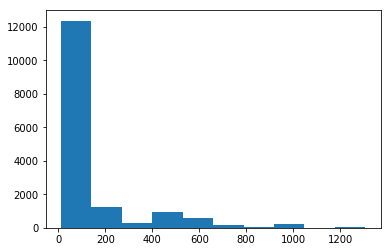

In [5]:
plt.hist(profile_length) #,bins=[10,20,30,40,50,60,70,80,90,100,110]
plt.show()
pro_df = pd.DataFrame(data={'profile':sorted(profile_length)})
pro_df.to_excel('data/tree-rep-profiles-partial/profile_dist.xlsx',index=False)

* remove too long profiles (processes)

In [6]:
outlier_len_profile = profile_stat_df.loc['outlier'].values[0]

In [7]:
# corpus = []
# window_size = 6
# dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
mv_dir = './data/tree-rep-profiles-partial/5.long/'
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
remove_pids = 0
nobyteseq = 0

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        for profile in hl_list:
            with open(profile,encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            if len(lines)> outlier_len_profile:
                dest_path = mv_dir + fam + '/' + tree + '/'
                if not os.path.exists(dest_path):
                    os.makedirs(dest_path,exist_ok=True)
                shutil.move(profile,dest_path+profile.split('/')[-1])
                byteseq = profile.split('.profile')[0] + '_byterep.pickle'
                try:
                    shutil.move(byteseq,dest_path+byteseq.split('/')[-1])
                except FileNotFoundError:
                    print(fam,tree)
                    nobyteseq +=1
                remove_pids +=1
print('remove processes:',remove_pids,'No byteseq:',nobyteseq)
            

100%|██████████| 184/184 [00:00<00:00, 222.32it/s]

remove processes: 2763 No byteseq: 0


In [8]:
def statistic_hash_pids(root_dir):
    fam_dir = next(os.walk(root_dir))[1]
    all_pids= []
    all_pid_list = []
    tree_count = 0
    for fam in tqdm(fam_dir):
        tree_dir = next(os.walk(root_dir + fam))[1]
        tree_count += len(tree_dir)
        for tree in tree_dir:
            in_directory = root_dir + fam +  '/' + tree + '/'
            hl_list = next(os.walk(in_directory))[2]
            hl_list = [os.path.join(in_directory, f) for f in hl_list]
            hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
            hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
            pid_list = [f.split('/')[-1] for f in hl_list]
            all_pids.extend(hash_list)
            all_pid_list.extend(pid_list)
#             print(fam,len(hash_list)) #DEBUG
    all_hash = set(all_pids)
    print('Samples#:',len(all_hash),',Processes#:',len(set(all_pid_list)),',Trees#:',tree_count)
    return all_hash, list(set(all_pid_list))

In [9]:
fam_dir = next(os.walk(root_dir))[1]
empty_tree = 0
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    fam_tree = {}
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        if len(hl_list) == 0: #移除tree底下的member僅有0個者
            shutil.move(root_dir + fam +  '/' + tree ,mv_dir+fam+'/'+tree)
            empty_tree +=1
print('Empty Tree#:',empty_tree)

root_dir = './data/tree-rep-profiles-partial/normal/'
temp = statistic_hash_pids(root_dir)
'''fam_dir = next(os.walk(root_dir))[1]
all_pids = []

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
        all_pids.extend(hash_list)
all_hash = set(all_pids)
len(all_hash) , len(all_pids) #濾掉過長的profile以後剩下的(samples, processes)'''

  0%|          | 0/184 [00:00<?, ?it/s]

Empty Tree#: 348


100%|██████████| 184/184 [00:00<00:00, 1759.21it/s]

Samples#: 6652 ,Processes#: 8829 ,Trees#: 1198


'fam_dir = next(os.walk(root_dir))[1]\nall_pids = []\n\nfor fam in tqdm(fam_dir):\n    tree_dir = next(os.walk(root_dir + fam))[1]\n    for tree in tree_dir:\n        in_directory = root_dir + fam +  \'/\' + tree + \'/\'\n        hl_list = next(os.walk(in_directory))[2]\n        hl_list = [os.path.join(in_directory, f) for f in hl_list]\n        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))\n        hash_list = [f.split(\'/\')[-1].split(\'_\')[0] for f in hl_list]\n        all_pids.extend(hash_list)\nall_hash = set(all_pids)\nlen(all_hash) , len(all_pids) #濾掉過長的profile以後剩下的(samples, processes)'

* family smaller than 15
* dict: key(fam): value(samples)

In [10]:
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
fam_pids_count = {}

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    tree_pids_count = []
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        tree_pids_count.append(len(hl_list))
    fam_pids_count[fam] = sum(tree_pids_count)

100%|██████████| 184/184 [00:00<00:00, 2048.18it/s]


In [11]:
fam_count = []
for i,v in fam_pids_count.items():
    if v == 0:
        print('No member:',i)
        continue
    fam_count.append(v)
fam_count_df = basic_statistics(fam_count)
fam_count_df #中位數=15

No member: 157.urelas_0.8
No member: 188.darkkomet_0.8
No member: 115.vundo_0.8
No member: 191.ganelp_0.8
No member: 125.rbot_0.8
No member: 87.krypt_0.8
No member: 152.sdbot_0.8
No member: 169.patched_0.8


,length
mean,74.181818
std,194.795641
mode,4.000000
min,3.000000
q1,7.000000
median,15.000000
q3,49.250000
max,1701.000000
iqr,42.250000
outlier,112.625000


In [12]:
fam_pids_count_df = pd.DataFrame.from_dict(fam_pids_count,orient='index',columns=['pids'])
fam_pids_count_df = fam_pids_count_df.sort_values(by=['pids'],ascending=False)
fam_pids_count_df

,pids
1.fakeav_0.8,1701
2.fakealert_0.8,1130
6.allaple_0.8,1007
3.kazy_0.8,809
4.zbot_0.8,633
7.virut_0.8,480
5.symmi_0.8,437
8.ursu_0.8,426
11.virtob_0.8,332
9.solimba_0.8,318


In [13]:
fam_pids_upper = fam_pids_count_df[fam_pids_count_df.pids > 15]
print('final processes#:',fam_pids_upper.pids.sum())
fam_pids_upper

final processes#: 12364


,pids
1.fakeav_0.8,1701
2.fakealert_0.8,1130
6.allaple_0.8,1007
3.kazy_0.8,809
4.zbot_0.8,633
7.virut_0.8,480
5.symmi_0.8,437
8.ursu_0.8,426
11.virtob_0.8,332
9.solimba_0.8,318


* move small families to 'smallFam' dir

In [14]:
fam_small_df = fam_pids_count_df[fam_pids_count_df.pids < 3]
small_families = fam_small_df.index.tolist()
small_families

['87.krypt_0.8',
 '125.rbot_0.8',
 '115.vundo_0.8',
 '188.darkkomet_0.8',
 '169.patched_0.8',
 '191.ganelp_0.8',
 '152.sdbot_0.8',
 '157.urelas_0.8']

In [15]:
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
mv_dir = './data/tree-rep-profiles-partial/6.smallFam/'
if not os.path.exists(mv_dir):
    os.makedirs(mv_dir,exist_ok=True)

for fam in tqdm(fam_dir):
    if fam in small_families:
        src = os.path.join(root_dir,fam)
        dest = os.path.join(mv_dir,fam)
        shutil.move(src,dest)

mv_dir = './data/tree-rep-profiles-partial/7.emptyTree_of5.Long/'
if not os.path.exists(mv_dir):
    os.makedirs(mv_dir,exist_ok=True)

fam_dir = next(os.walk(root_dir))[1]
empty_tree = 0
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    fam_tree = {}
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        if len(hl_list) == 0: #移除tree底下的member僅有0個者
            shutil.move(root_dir + fam +  '/' + tree ,mv_dir+fam+'/'+tree)
            empty_tree +=1
print('Empty Tree#:',empty_tree)
        
fam_dir = next(os.walk(root_dir))[1]
tree_count = 0
all_pids= []
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    tree_count += len(tree_dir)
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
        all_pids.extend(hash_list)
all_hash = set(all_pids)
print(len(all_hash) , len(all_pids),tree_count,len(fam_dir)) #final dataset的(samples, processes,trees#,fam#)
temp = statistic_hash_pids(root_dir)

  0%|          | 0/176 [00:00<?, ?it/s]

Empty Tree#: 0


  0%|          | 0/176 [00:00<?, ?it/s]

6652 13056 1198 176


100%|██████████| 176/176 [00:00<00:00, 1731.99it/s]

Samples#: 6652 ,Processes#: 8829 ,Trees#: 1198


In [16]:
def statistic_hash_pids_fam(root_dir):
    fam_dir = next(os.walk(root_dir))[1]
    fam_count = {}
    for fam in tqdm(fam_dir):
        tree_dir = next(os.walk(root_dir + fam))[1]
#         fam_count[fam] = 0
        all_pids = []
        all_hash = []
        for tree in tree_dir:
            in_directory = root_dir + fam +  '/' + tree + '/'
            hl_list = next(os.walk(in_directory))[2]
            hl_list = [os.path.join(in_directory, f) for f in hl_list]
            hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
            hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
            pid_list = [f.split('/')[-1] for f in hl_list]
            all_pids.extend(hash_list)
#             all_pid_list.extend(pid_list)
        fam_count[fam] = (len(set(all_pids)),len(all_pids))
#             print(fam,len(hash_list)) #DEBUG
#     all_hash = set(all_pids)
    print('(Samples# , PIDs#)')
    return fam_count

In [17]:
fam_count = statistic_hash_pids_fam('./data/tree-rep-profiles-partial/normal/')
nums = []
names = []
for i,v in fam_count.items():
    nums.append(int(i.split('.')[0]))
    names.append(i.split('.')[1].split('_')[0])
    print(i,v)

100%|██████████| 176/176 [00:00<00:00, 1704.66it/s]

(Samples# , PIDs#)
5.symmi_0.8 (383, 437)
117.koutodoor_0.8 (7, 9)
150.minggy_0.8 (10, 14)
69.onlinegames_0.8 (6, 9)
31.kdz_0.8 (31, 36)
38.msil_0.8 (28, 48)
35.nimnul_0.8 (54, 95)
103.yantai_0.8 (26, 26)
62.renos_0.8 (13, 13)
21.ramnit_0.8 (110, 176)
123.archsms_0.8 (7, 7)
167.hybris_0.8 (4, 5)
92.vjadtre_0.8 (5, 9)
144.wbna_0.8 (5, 5)
50.brresmon_0.8 (47, 47)
51.shodi_0.8 (44, 59)
119.chydo_0.8 (6, 6)
25.installcore_0.8 (39, 50)
88.clickdownload_0.8 (19, 22)
27.softpulse_0.8 (44, 71)
158.peed_0.8 (6, 7)
178.installmonetizer_0.8 (7, 15)
56.shiz_0.8 (8, 14)
57.mikey_0.8 (18, 22)
13.graftor_0.8 (109, 134)
42.sirefef_0.8 (40, 51)
43.mira_0.8 (59, 76)
53.simda_0.8 (5, 8)
54.soltern_0.8 (50, 61)
89.mywebsearch_0.8 (13, 13)
173.inffinity_0.8 (5, 5)
131.ndropper_0.8 (1, 4)
39.elkern_0.8 (7, 18)
127.gepys_0.8 (9, 9)
121.fiseria_0.8 (10, 18)
49.upatre_0.8 (44, 51)
45.firseria_0.8 (25, 36)
166.prepender_0.8 (4, 4)
105.crytex_0.8 (7, 9)
176.cryptolocker_0.8 (12, 12)
172.vbinject_0.8 (2, 3)
76.vi

In [18]:
df = pd.DataFrame.from_dict(fam_count,orient='index')
df['idx'] = nums
df['names'] = names
df = df.sort_values(['idx'])
df = df[['names',0,1]]

df.to_excel('./data/tree-rep-profiles-partial/family_samples_pids.xlsx')
df

,names,0,1
1.fakeav_0.8,fakeav,1629,1701
2.fakealert_0.8,fakealert,1091,1130
3.kazy_0.8,kazy,712,809
4.zbot_0.8,zbot,554,633
5.symmi_0.8,symmi,383,437
6.allaple_0.8,allaple,512,1007
7.virut_0.8,virut,312,480
8.ursu_0.8,ursu,321,426
9.solimba_0.8,solimba,288,318
10.zusy_0.8,zusy,203,254


### 還原feature
* 合併家族以前先還原bert feature

In [19]:
src_dir = './data/tree-rep-profiles_one2many/normal/'

In [20]:
def restore_feature(root_dir,src_dir=src_dir):
# root_dir = './data/tree-rep-profiles-partial/normal/'
    fam_dir = next(os.walk(root_dir))[1]
    for fam in tqdm(fam_dir):
        tree_dir = next(os.walk(root_dir + fam))[1]
        for tree in tree_dir:
            in_directory = root_dir + fam +  '/' + tree + '/'
            hl_list = next(os.walk(in_directory))[2]
            hl_list = [os.path.join(in_directory, f) for f in hl_list]
            hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
            for hl in hl_list:
                files = glob.glob(src_dir + fam + '/' + tree + '/'+hl.split('/')[-1].replace('.profile','*'))
                for file in files:
                    shutil.copy(file,in_directory+file.split('/')[-1])

In [21]:
root_dir = './data/tree-rep-profiles-partial/normal/'
restore_feature(root_dir)
# root_dir = './data/tree-rep-profiles-partial/DEV/'
# restore_feature(root_dir)
# root_dir = './data/tree-rep-profiles-partial/TEST/'
# restore_feature(root_dir)

100%|██████████| 176/176 [00:23<00:00,  7.62it/s]


## Aliases combine

In [22]:
# aliases分析
with open('./data/familyAliases.csv','r') as f:
    reader = csv.reader(f)
    my_li = list(reader)
aliase_li = []
for li in my_li:
    aliase_li.append(list(filter(None, li)))
aliase_li

[['allaple', 'rahack'],
 ['autoit', 'barys', 'kryptik'],
 ['zbot',
  'fakealert',
  'bredo',
  'upatre',
  'fakeav',
  'tepfer',
  'zeus',
  'kneber',
  'wsnpoem',
  'citadel'],
 ['delf', 'hoax', 'vbkrypt'],
 ['eggnog', 'elkern'],
 ['graftor', 'ibryte', 'ipamor', 'startpage'],
 ['installerex', 'hotbar', 'installrex'],
 ['kazy', 'kdz', 'symmi', 'zusy', 'malagent', 'sillyfdc', 'ursu'],
 ['loadmoney', 'lmn', 'razy'],
 ['firseria', 'fiseria', 'morstar', 'solimba'],
 ['downloadadmin', 'downloa', 'mikey'],
 ['madang', 'madangel'],
 ['ramnit', 'nimnul'],
 ['virtob', 'sality', 'virut', 'kashu', 'tanatos', 'virux'],
 ['softpulse', 'soft', 'softpuls', 'pulsoft', 'bawswerps']]

In [23]:
# 合併家族數目
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
c=0
combine_dict={}
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for aliase in aliase_li:
        name = fam.split('_')[0].split('.')[1]
        if (name in aliase) and (name != aliase[0]):
            try:
#             print('最終家族:',aliase[0],'被合併家族:',name)
                combine_dict[aliase[0]] = aliase[0]+ '、'+ name
            except:
                combine_dict[aliase[0]] = name
            for tree in tree_dir:
                ori_path = root_dir + fam + '/' + tree + '/'
                dest_path = glob.glob(root_dir +'*'+aliase[0]+'*')[0]+'/' + tree + '/'
                copy_tree(ori_path,dest_path)
            shutil.rmtree(root_dir + fam)
            c+=1
            
#             print(aliase)
print(c)
combine_dict

100%|██████████| 176/176 [00:03<00:00, 44.41it/s]

32


{'kazy': 'kazy、zusy',
 'ramnit': 'ramnit、nimnul',
 'downloadadmin': 'downloadadmin、downloa',
 'eggnog': 'eggnog、elkern',
 'firseria': 'firseria、solimba',
 'zbot': 'zbot、tepfer',
 'virtob': 'virtob、sality',
 'autoit': 'autoit、kryptik',
 'madang': 'madang、madangel',
 'graftor': 'graftor、startpage',
 'installerex': 'installerex、installrex',
 'loadmoney': 'loadmoney、lmn',
 'delf': 'delf、vbkrypt',
 'softpulse': 'softpulse、soft',
 'allaple': 'allaple、rahack'}

In [24]:
# 統計
fam_count = statistic_hash_pids_fam('./data/tree-rep-profiles-partial/normal/')
nums = []
names = []
for i,v in fam_count.items():
    nums.append(int(i.split('.')[0]))
    names.append(i.split('.')[1].split('_')[0])
    print(i,v)

# 統計
df = pd.DataFrame.from_dict(fam_count,orient='index')
df['idx'] = nums
df['names'] = names
df = df.sort_values(['idx'])
df = df[['names',0,1]]

# df.to_excel('./data/tree-rep-profiles-partial/family_samples_pids_aliasesOut.xlsx')
df

100%|██████████| 144/144 [00:00<00:00, 660.01it/s]

(Samples# , PIDs#)
117.koutodoor_0.8 (7, 9)
150.minggy_0.8 (10, 14)
69.onlinegames_0.8 (6, 9)
38.msil_0.8 (28, 48)
103.yantai_0.8 (26, 26)
62.renos_0.8 (13, 13)
21.ramnit_0.8 (117, 271)
123.archsms_0.8 (7, 7)
167.hybris_0.8 (4, 5)
92.vjadtre_0.8 (5, 9)
144.wbna_0.8 (5, 5)
50.brresmon_0.8 (47, 47)
51.shodi_0.8 (44, 59)
119.chydo_0.8 (6, 6)
25.installcore_0.8 (39, 50)
88.clickdownload_0.8 (19, 22)
27.softpulse_0.8 (144, 176)
158.peed_0.8 (6, 7)
178.installmonetizer_0.8 (7, 15)
56.shiz_0.8 (8, 14)
13.graftor_0.8 (148, 195)
42.sirefef_0.8 (40, 51)
43.mira_0.8 (59, 76)
53.simda_0.8 (5, 8)
54.soltern_0.8 (50, 61)
89.mywebsearch_0.8 (13, 13)
173.inffinity_0.8 (5, 5)
131.ndropper_0.8 (1, 4)
127.gepys_0.8 (9, 9)
45.firseria_0.8 (345, 429)
166.prepender_0.8 (4, 4)
105.crytex_0.8 (7, 9)
176.cryptolocker_0.8 (12, 12)
172.vbinject_0.8 (2, 3)
76.virlock_0.8 (17, 22)
82.mydoom_0.8 (6, 6)
130.llac_0.8 (3, 3)
101.navattle_0.8 (3, 3)
140.valla_0.8 (4, 4)
97.viking_0.8 (5, 7)
41.outbrowse_0.8 (60, 102)
6

,names,0,1
3.kazy_0.8,kazy,1650,1962
4.zbot_0.8,zbot,2311,3582
6.allaple_0.8,allaple,512,1299
11.virtob_0.8,virtob,343,853
12.loadmoney_0.8,loadmoney,153,243
13.graftor_0.8,graftor,148,195
14.vobfus_0.8,vobfus,181,206
17.expiro_0.8,expiro,101,156
18.sytro_0.8,sytro,153,199
21.ramnit_0.8,ramnit,117,271


In [25]:
#移除小家族
root_dir = './data/tree-rep-profiles-partial/normal/'
unk_fam = './data/tree-rep-profiles-partial/6.smallFam/'
smallfam = df[df[0] <=15].index.tolist()
for fam in smallfam:
    ori_path = root_dir + fam + '/'
    dest_path = unk_fam + fam + '/'
    copy_tree(ori_path,dest_path)
    shutil.rmtree(root_dir + fam)

In [26]:
# 統計
fam_count = statistic_hash_pids_fam('./data/tree-rep-profiles-partial/normal/')
nums = []
names = []
for i,v in fam_count.items():
    nums.append(int(i.split('.')[0]))
    names.append(i.split('.')[1].split('_')[0])
#     print(i,v)
df = pd.DataFrame.from_dict(fam_count,orient='index')
df['idx'] = nums
df['names'] = names
df = df.sort_values(['idx'])
df = df[['names',0,1]]

df.to_excel('./data/tree-rep-profiles-partial/family_samples_pids_aliasesOut.xlsx')

print(len(df))
df 

100%|██████████| 52/52 [00:00<00:00, 261.35it/s]


(Samples# , PIDs#)
52


,names,0,1
3.kazy_0.8,kazy,1650,1962
4.zbot_0.8,zbot,2311,3582
6.allaple_0.8,allaple,512,1299
11.virtob_0.8,virtob,343,853
12.loadmoney_0.8,loadmoney,153,243
13.graftor_0.8,graftor,148,195
14.vobfus_0.8,vobfus,181,206
17.expiro_0.8,expiro,101,156
18.sytro_0.8,sytro,153,199
21.ramnit_0.8,ramnit,117,271


In [27]:
root_dir = './data/tree-rep-profiles-partial/normal/'
samples_hash_train = statistic_hash_pids(root_dir) 

100%|██████████| 52/52 [00:00<00:00, 266.40it/s]

Samples#: 6360 ,Processes#: 8450 ,Trees#: 1038


## Train, Dev , Test Set

In [28]:
root_dir = './data/tree-rep-profiles-partial/normal/'
unk_fam = './data/tree-rep-profiles-partial/6.smallFam/'
all_df = pd.read_csv('./data/tree-rep-profiles-partial/process2family_df.csv')
fam_dir = next(os.walk(root_dir))[1]
fam_unk = next(os.walk(unk_fam))[1]
normal_fam = [x.split('_')[0] for x in fam_dir]
sorted(fam_dir)#正常最後要拿下去train的family

['103.yantai_0.8',
 '104.mresmon_0.8',
 '11.virtob_0.8',
 '111.vbran_0.8',
 '12.loadmoney_0.8',
 '124.avmh_0.8',
 '13.graftor_0.8',
 '14.vobfus_0.8',
 '151.downloadadmin_0.8',
 '17.expiro_0.8',
 '18.sytro_0.8',
 '21.ramnit_0.8',
 '22.domaiq_0.8',
 '25.installcore_0.8',
 '27.softpulse_0.8',
 '28.strictor_0.8',
 '29.delf_0.8',
 '3.kazy_0.8',
 '30.mplug_0.8',
 '32.browsefox_0.8',
 '33.autoit_0.8',
 '37.parite_0.8',
 '38.msil_0.8',
 '4.zbot_0.8',
 '41.outbrowse_0.8',
 '42.sirefef_0.8',
 '43.mira_0.8',
 '44.screensaver_0.8',
 '45.firseria_0.8',
 '46.killav_0.8',
 '47.somoto_0.8',
 '50.brresmon_0.8',
 '51.shodi_0.8',
 '54.soltern_0.8',
 '55.zygug_0.8',
 '59.megasearch_0.8',
 '6.allaple_0.8',
 '60.conjar_0.8',
 '63.jorik_0.8',
 '64.installerex_0.8',
 '65.shipup_0.8',
 '66.bdmj_0.8',
 '71.eggnog_0.8',
 '75.fesber_0.8',
 '76.virlock_0.8',
 '77.lollipop_0.8',
 '78.vilsel_0.8',
 '80.madang_0.8',
 '81.picsys_0.8',
 '84.directdow_0.8',
 '88.clickdownload_0.8',
 '96.mabezat_0.8']

* remove empty tree

In [29]:
# mv_dir = './data/tree-rep-profiles-partial/7.emptyTree_of5.Long/'
# if not os.path.exists(mv_dir):
#     os.makedirs(mv_dir,exist_ok=True)

# empty_tree = 0
# for fam in tqdm(fam_dir):
#     tree_dir = next(os.walk(root_dir + fam))[1]
#     fam_tree = {}
#     for tree in tree_dir:
#         in_directory = root_dir + fam +  '/' + tree + '/'
#         hl_list = next(os.walk(in_directory))[2]
#         hl_list = [os.path.join(in_directory, f) for f in hl_list]
#         hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
#         if len(hl_list) == 0:
#             shutil.move(root_dir + fam +  '/' + tree ,mv_dir+fam+'/'+tree)
#             empty_tree +=1
# print('Empty Tree#:',empty_tree)

move file to valid & test

In [30]:
valid_dir = './data/tree-rep-profiles-partial/DEV/'
test_dir = './data/tree-rep-profiles-partial/TEST/'

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    fam_tree = {}
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        fam_tree[tree]=len(hl_list)
        temp = pd.DataFrame.from_dict(fam_tree,orient='index',columns=['pids'])
        temp = temp.sort_values(by=['pids'])
        if len(hl_list)>10:# 從各tree拿一個sample給dev一個給test
            dest_path = valid_dir + fam + '/' + tree + '/'
            if not os.path.exists(dest_path):
                os.makedirs(dest_path,exist_ok=True)
            ran = random.randint(0,len(hl_list)-1)
            byteseq = hl_list[ran].split('.profile')[0] + '_byterep.pickle'
            feature = hl_list[ran].split('.profile')[0] + '_tokenfeature.pkl'
            clean = hl_list[ran].split('.profile')[0] +'.profile_clean'
            clsf = hl_list[ran].split('.profile')[0] + '_clsfeature.pkl'
            shutil.move(hl_list[ran], dest_path+ hl_list[ran].split('/')[-1])
            shutil.move(byteseq,dest_path)
            shutil.move(feature,dest_path)
            shutil.move(clean,dest_path)
            shutil.move(clsf,dest_path)
            
            dest_path = test_dir + fam + '/' + tree + '/'
            if not os.path.exists(dest_path):
                os.makedirs(dest_path,exist_ok=True)
            try:
                byteseq = hl_list[ran+1].split('.profile')[0] + '_byterep.pickle'
                feature = hl_list[ran+1].split('.profile')[0] + '_tokenfeature.pkl'
                clean = hl_list[ran+1].split('.profile')[0] +'.profile_clean'
                clsf = hl_list[ran+1].split('.profile')[0] + '_clsfeature.pkl'
                shutil.move(hl_list[ran+1], dest_path+ hl_list[ran+1].split('/')[-1])
                shutil.move(byteseq,dest_path)
                shutil.move(feature,dest_path)
                shutil.move(clean,dest_path)
                shutil.move(clsf,dest_path)
            except IndexError:    
                byteseq = hl_list[ran-1].split('.profile')[0] + '_byterep.pickle'
                feature = hl_list[ran-1].split('.profile')[0] + '_tokenfeature.pkl'
                clean = hl_list[ran-1].split('.profile')[0] +'.profile_clean'
                clsf = hl_list[ran-1].split('.profile')[0] + '_clsfeature.pkl'
                shutil.move(hl_list[ran-1], dest_path+ hl_list[ran-1].split('/')[-1])
                shutil.move(byteseq,dest_path)
                shutil.move(feature,dest_path)
                shutil.move(clean,dest_path)
                shutil.move(clsf,dest_path)
    if len(fam_tree)>10: #拿一棵樹給dev一顆給train
        test_tree_name = temp.iloc[0].name
        valid_tree_name = temp.iloc[1].name
        dest_path = valid_dir + fam + '/' + valid_tree_name + '/'
        ori_path = root_dir + fam +  '/' + valid_tree_name + '/'
        if not os.path.exists(dest_path):
            os.makedirs(dest_path,exist_ok=True)
        copy_tree(ori_path,dest_path)
        shutil.rmtree(ori_path)
        ori_path = root_dir + fam +  '/' + test_tree_name + '/'
        dest_path = test_dir + fam + '/' + test_tree_name + '/'
        if not os.path.exists(dest_path):
            os.makedirs(dest_path,exist_ok=True)
        copy_tree(ori_path,dest_path)
        shutil.rmtree(ori_path)
#     else: #最大tree挑選兩個sample
#         VTtree = temp.iloc[-1].name 
#         in_directory = root_dir + fam +  '/' + VTtree + '/'
#         hl_list = next(os.walk(in_directory))[2]
#         hl_list = [os.path.join(in_directory, f) for f in hl_list]
#         hl_list = list(filter(lambda f: f.endswith((".profile")), hl_list))
#         hl_list = sorted(hl_list)
#         dest_path = valid_dir + fam + '/' + VTtree + '/'
#         if not os.path.exists(dest_path):
#             os.makedirs(dest_path,exist_ok=True)
#         ran = random.randint(0,len(hl_list)-1)
#         shutil.move(hl_list[ran],dest_path + hl_list[ran].split('/')[-1])
#         byteseq = hl_list[ran].split('.profile')[0] + '_byterep.pickle'
#         try:
#             shutil.move(byteseq,dest_path + byteseq.split('/')[-1])
#         except FileNotFoundError:
#             print('No Byte String:',fam,tree)
#         dest_path = test_dir + fam + '/' + VTtree + '/'
#         if not os.path.exists(dest_path):
#             os.makedirs(dest_path,exist_ok=True)
#         try:
#             shutil.move(hl_list[ran+1],dest_path + hl_list[ran+1].split('/')[-1]) #所有同樣名稱的都要拿? 可能會產生空樹
#             byteseq = hl_list[ran+1].split('.profile')[0] + '_byterep.pickle'
#             try:
#                 shutil.move(byteseq,dest_path + byteseq.split('/')[-1])
#             except FileNotFoundError:
#                 print('No Byte String:',fam,tree)
#         except IndexError:
#             shutil.move(hl_list[ran-1],dest_path + hl_list[ran-1].split('/')[-1])
#             byteseq = hl_list[ran-1].split('.profile')[0] + '_byterep.pickle'
#             try:
#                 shutil.move(byteseq,dest_path + byteseq.split('/')[-1])
#             except FileNotFoundError:
#                 print('No Byte String:',fam,tree)



100%|██████████| 52/52 [00:01<00:00, 49.59it/s]


* 計算train : valid : test比例
* 依照比例分配unk_pid數目

In [31]:
#移除沒有在DEV跟TEST裡面的family
root_dir = './data/tree-rep-profiles-partial/DEV/'
fam_dir_valid = next(os.walk(root_dir))[1]
root_dir = './data/tree-rep-profiles-partial/normal/'
unk_fam = './data/tree-rep-profiles-partial/6.smallFam/'
fam_dir_train = next(os.walk(root_dir))[1]
for fam in fam_dir_train:
    if fam not in fam_dir_valid:
        ori_path = root_dir + fam + '/'
        dest_path = unk_fam + fam + '/'
        copy_tree(ori_path,dest_path)
        shutil.rmtree(root_dir + fam)
        print(fam)

50.brresmon_0.8
25.installcore_0.8
76.virlock_0.8
80.madang_0.8
96.mabezat_0.8
77.lollipop_0.8
28.strictor_0.8
46.killav_0.8


In [32]:
root_dir = './data/tree-rep-profiles-partial/DEV/'
samples_hash_valid = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/TEST/'
samples_hash_test = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/normal/'
samples_hash_train = statistic_hash_pids(root_dir) 
fam_dir = next(os.walk(root_dir))[1]
normal_fam = [x.split('_')[0] for x in fam_dir]

  0%|          | 0/44 [00:00<?, ?it/s]

Samples#: 255 ,Processes#: 270 ,Trees#: 237
Samples#: 254 ,Processes#: 264 ,Trees#: 237


100%|██████████| 44/44 [00:00<00:00, 238.46it/s]


Samples#: 6071 ,Processes#: 8027 ,Trees#: 950


In [33]:
# 純統計
unk_pid = []
for fam in tqdm(fam_unk):
    tree_dir = next(os.walk(unk_fam + fam))[1]
    tree_count += len(tree_dir)
    for tree in tree_dir:
        in_directory = unk_fam + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('.')[0] for f in hl_list]
        for pid in hash_list:
            profile_df = all_df[all_df.profile == pid]
            if profile_df[normal_fam].sum().sum() == 0:
                unk_pid.append(profile_df.profile.values[0])
unk_hash = [x.split('_')[0] for x in unk_pid]
unk_hash = list(set(unk_hash))
print('UNK_Samples#:',len(unk_hash),'UNK_Processes#:',len(set(unk_pid)))

100%|██████████| 100/100 [00:01<00:00, 51.96it/s]

UNK_Samples#: 303 UNK_Processes#: 379


* 依照hash來分valid,test,train set
* 利用random比例來丟同樣samples到同一個set當中
* **暫時不做**

In [34]:
'''train_unk_path = './data/tree-rep-profiles-partial/normal/0.unknown/G0/'
valid_unk_path = './data/tree-rep-profiles-partial/DEV/0.unknown/G0/'
test_unk_path = './data/tree-rep-profiles-partial/TEST/0.unkwown/G0/'
if not os.path.exists(train_unk_path):
    os.makedirs(train_unk_path,exist_ok=True)
if not os.path.exists(valid_unk_path):
    os.makedirs(valid_unk_path,exist_ok=True)
if not os.path.exists(test_unk_path):
    os.makedirs(test_unk_path,exist_ok=True)

used_hashes = []
for fam in tqdm(fam_unk):
    tree_dir = next(os.walk(unk_fam + fam))[1]
    tree_count += len(tree_dir)
    for tree in tree_dir:
        in_directory = unk_fam + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('.')[0] for f in hl_list]
        for pid in hash_list:
            profile_df = all_df[all_df.profile == pid]
            if profile_df[normal_fam].sum().sum() == 0:
                unk_hash = profile_df.profile.values[0].split('_')[0]
                if unk_hash in set(used_hashes):
                    break
                used_hashes.append(unk_hash)
                ran = random.randint(1,len(samples_hash_train)+len(samples_hash_valid)+len(samples_hash_test))
                unk_files = []
                duplicate_pid = []
                for filepath in Path(unk_fam).glob('**/'+unk_hash+'*'):
                    pid = str(filepath).split('/')[-1]
                    if pid in set(duplicate_pid):
                        break
                    duplicate_pid.append(pid)
                    unk_files.append(filepath)
                unk_files = list(set(unk_files))
                if ran <= len(samples_hash_valid): #valid
                    for file in unk_files:
                        shutil.move(str(file),valid_unk_path)
                elif ran < len(samples_hash_valid)+ len(samples_hash_test): #test
                    for file in unk_files:
                        shutil.move(str(file),test_unk_path)
                else: #train
                    for file in unk_files:
                        shutil.move(str(file),train_unk_path)
                    '''

'train_unk_path = \'./data/tree-rep-profiles-partial/normal/0.unknown/G0/\'\nvalid_unk_path = \'./data/tree-rep-profiles-partial/DEV/0.unknown/G0/\'\ntest_unk_path = \'./data/tree-rep-profiles-partial/TEST/0.unkwown/G0/\'\nif not os.path.exists(train_unk_path):\n    os.makedirs(train_unk_path,exist_ok=True)\nif not os.path.exists(valid_unk_path):\n    os.makedirs(valid_unk_path,exist_ok=True)\nif not os.path.exists(test_unk_path):\n    os.makedirs(test_unk_path,exist_ok=True)\n\nused_hashes = []\nfor fam in tqdm(fam_unk):\n    tree_dir = next(os.walk(unk_fam + fam))[1]\n    tree_count += len(tree_dir)\n    for tree in tree_dir:\n        in_directory = unk_fam + fam +  \'/\' + tree + \'/\'\n        hl_list = next(os.walk(in_directory))[2]\n        hl_list = [os.path.join(in_directory, f) for f in hl_list]\n        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))\n        hash_list = [f.split(\'/\')[-1].split(\'.\')[0] for f in hl_list]\n        for pid in hash_list:\n  

以上UNK暫時不做

In [35]:
# trees# 要減1
root_dir = './data/tree-rep-profiles-partial/DEV/'
samples_hash_valid, samples_pid_valid = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/TEST/'
samples_hash_test, samples_pid_test = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/normal/'
samples_hash_train, samples_pid_train = statistic_hash_pids(root_dir) 

  0%|          | 0/44 [00:00<?, ?it/s]

Samples#: 255 ,Processes#: 270 ,Trees#: 237
Samples#: 254 ,Processes#: 264 ,Trees#: 237


100%|██████████| 44/44 [00:00<00:00, 232.04it/s]

Samples#: 6071 ,Processes#: 8027 ,Trees#: 950


* prepare Sent2Vec training data
* save profile file name of [train, dev, test] to pickle

In [36]:
count = 0
for i in range(len(samples_pid_valid)):
#     for file in glob.glob('./data/tree-rep-profiles-partial/normal/*/*'+samples_pid_valid[i].split('_')[0]+'*'):
    for file in glob.glob('./data/tree-rep-profiles-partial/normal/*/*/'+samples_pid_valid[i].split('.')[0]+'*'):
        dest_file = file.replace('normal','DEV')
        dest_dir = '/'.join(dest_file.split('/')[:-1]) + '/'
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir,exist_ok=True)
        shutil.move(file,dest_file)
        count +=1
print(count/2)
count = 0
for i in range(len(samples_pid_test)):
#     for file in glob.glob('./data/tree-rep-profiles-partial/normal/*/*'+samples_pid_valid[i].split('_')[0]+'*'):
    for file in glob.glob('./data/tree-rep-profiles-partial/normal/*/*/'+samples_pid_test[i].split('.')[0]+'*'):
        dest_file = file.replace('normal','TEST')
        dest_dir = '/'.join(dest_file.split('/')[:-1]) + '/'
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir,exist_ok=True)
        shutil.move(file,dest_file)
        count +=1
print(count/2)

405.0
392.5


In [37]:
mv_dir = './data/tree-rep-profiles-partial/7.emptyTree_of5.Long/'
if not os.path.exists(mv_dir):
    os.makedirs(mv_dir,exist_ok=True)
    
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
empty_tree = 0
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    fam_tree = {}
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        if len(hl_list) == 0: #移除tree底下的member僅有0個者
            shutil.move(root_dir + fam +  '/' + tree ,mv_dir+fam+'/'+tree)
            empty_tree +=1
print('Empty Tree#:',empty_tree)

100%|██████████| 44/44 [00:00<00:00, 259.86it/s]

Empty Tree#: 4


In [38]:
# trees# 要減1
root_dir = './data/tree-rep-profiles-partial/DEV/'
samples_hash_valid, samples_pid_valid = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/TEST/'
samples_hash_test, samples_pid_test = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/normal/'
samples_hash_train, samples_pid_train = statistic_hash_pids(root_dir) 

 68%|██████▊   | 30/44 [00:00<00:00, 296.48it/s]

Samples#: 255 ,Processes#: 270 ,Trees#: 263
Samples#: 254 ,Processes#: 264 ,Trees#: 274


100%|██████████| 44/44 [00:00<00:00, 245.86it/s]

Samples#: 5885 ,Processes#: 7771 ,Trees#: 946


In [39]:
pickle.dump(file=open('./data/tree-rep-profiles-partial/TRAIN_pidNames.pkl','wb'),obj=samples_pid_train)
pickle.dump(file=open('./data/tree-rep-profiles-partial/DEV_pidNames.pkl','wb'),obj=samples_pid_valid)
pickle.dump(file=open('./data/tree-rep-profiles-partial/TEST_pidNames.pkl','wb'),obj=samples_pid_test)
pickle.dump(file=open('./data/tree-rep-profiles-partial/UNK_hask.pkl','wb'),obj=unk_hash)

# for sent2vec only (not necessary)

In [8]:
dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"\=\_]+\ *" #等號、底線被保留
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
api_length = []
profile_length = []

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        for profile in hl_list:
            with open(profile,encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            for line in lines:
                temp = re.sub(dil," ",line.lower())
                temp = temp.split(" ")
                temp = list(filter(None, temp))
                api_length.append(len(temp))

100%|██████████| 44/44 [00:06<00:00,  6.70it/s]


In [9]:
basic_statistics(api_length)

,length
mean,15.099237
std,4.444819
mode,16.000000
min,3.000000
q1,13.000000
median,16.000000
q3,18.000000
max,36.000000
iqr,5.000000
outlier,25.500000


woParam : 16
Param: 13